In [3]:
from shiny import App, render, ui
import shinyswatch
import requests
from bs4 import BeautifulSoup
from googleapiclient.discovery import build
import googlemaps
import tweepy
from transformers import pipeline
import spacy
import os
import google.generativeai as genai
import re 
from spacytextblob.spacytextblob import SpacyTextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from dotenv import load_dotenv

In [4]:
load_dotenv()

True

In [5]:
url_test = 'https://es.m.wikipedia.org/wiki/Agapornis'

In [6]:
def wikipedia_content(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Lanza una excepción para códigos de error HTTP
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        text = "\n".join([p.get_text() for p in paragraphs])
        return text[:500] + "..." if len(text) > 500 else text # Mostrar un fragmento por ahora
    except requests.exceptions.RequestException as e:
        return f"Error al acceder a Wikipedia: {e}"


In [8]:
testText = wikipedia_content(url_test)

In [9]:
def sentiment_output(input_text):
    nlp_sentiment = None
    try: 
        nlp_sentiment = spacy.load("es_core_news_md")
        nlp_sentiment.add_pipe('spacytextblob')
    except Exception as e:  
        print(f"Error al cargar el modelo de Spacy: {e}")
        return ui.output_text("sentiment_error", f"Error al cargar el modelo de Spacy: {e}")
    all_text_to_analyze ={
        #"Comentarios de YouTube": input.youtube_comments(),
        #"Comentarios de Google Maps": input.maps_comments(),
        #"Posts de Twitter": input.twitter_posts(),
        "Texto de Wikipedia": input_text            
    }
    print(f"Texto a analizar en sentimientos: {all_text_to_analyze}")
    sentiment_data = []
    for source, text in all_text_to_analyze.items():
        if text and not text.startswith("Error"):
            try:
                doc = nlp_sentiment(text)
                polarity = doc._.blob.polarity  
                sentiment='Neutral'
                if polarity > 0.1:
                    sentiment = 'Positivo'
                elif polarity < -0.1:
                    sentiment = 'Negativo'
                sentiment_data.append({"Source": source, "Sentiment": sentiment})
            except Exception as e:
                print(f"Error analyzing sentiment for {source}: {e}")
        else:
            print(f"No text available for sentiment analysis for {source}")
    if not sentiment_data:
        return ui.output_text("No hay texto para analizar.")
        
    df_sentiment= pd.DataFrame(sentiment_data)
    sentiment_counts= df_sentiment.groupby('Source')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)
    fig, ax = plt.subplots(figsize=(10, 6))
    sentiment_counts.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Distribución de Sentimientos')
    plt.xlabel("Source")
    plt.ylabel("Percentage")
    plt.xticks(rotation=45, ha="right")

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1%}', (x + width/2, y + height/2), ha='center', va='center')

    plt.tight_layout()
    return fig


Texto a analizar en sentimientos: {'Texto de Wikipedia': 'Agapornis es un género de aves psitaciformes de la familia Psittacidae, cuyos miembros son nativos de África, y son conocidos comúnmente como inseparables, periquitos de amor o aves del amor.\n\nSon loros pequeños, de cola corta y de plumaje muy colorido. El tamaño de las nueve especies está comprendido entre 13 y 16\xa0cm. Se alimentan de semillas, frutas y yemas. Tienen una vida media entre diez y doce años (aunque no es difícil que en cautividad y con unos cuidados adecuados puedan llegar a vivir ...'}


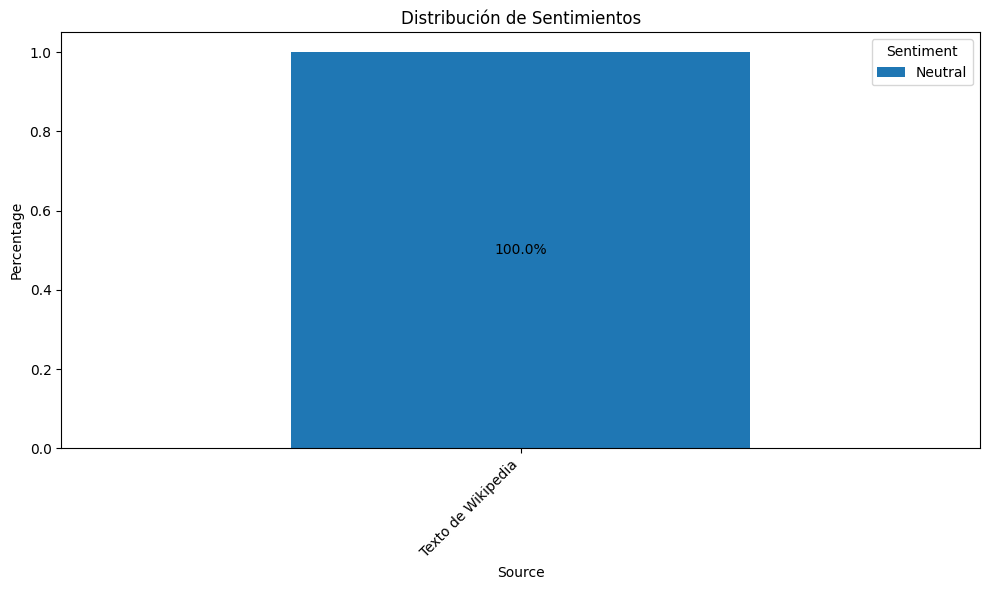

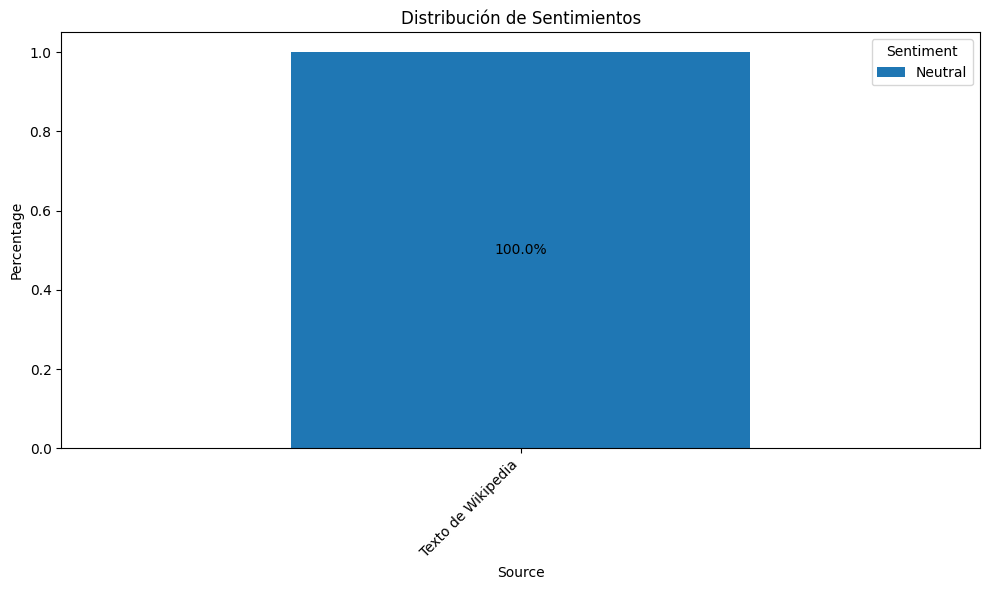

In [10]:
sentiment_output(testText)

In [ ]:
def summary_output(input):
    summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")
    summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")
    summary = summarizer(input, max_length=150, min_length=30, do_sample=False)[0]['summary_text']
    return f"Resumen:\n{summary}"
'''
def summary_output():
        summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")
        #summarizer = pipeline("summarization", model="ELiRF/mt5-base-dacsa-es")
        all_text_to_summarize = ""
        wikipedia_text = input.wikipedia_content()
        print(f"Contenido wikipedia:\n{wikipedia_text[:200]}") 
        youtube_info_text = input.youtube_info()
        print(f"Contenido youtube:\n{youtube_info_text[:200]}")        
        maps_info_text = input.maps_info()
        print(f"Contenido maps:\n{maps_info_text[:200]}")
        twitter_posts_text = input.twitter_posts()
        print(f"Contenido twitter:\n{twitter_posts_text[:200]}")    
        if wikipedia_text and not wikipedia_text.startswith("Error"):
            all_text_to_summarize += wikipedia_text + '\n\n'
        if youtube_info_text and not youtube_info_text.startswith("Error"):
            all_text_to_summarize += youtube_info_text + '\n\n'
        if maps_info_text and not maps_info_text.startswith("Error"):
            all_text_to_summarize += maps_info_text + '\n\n'
        if twitter_posts_text and not twitter_posts_text.startswith("Error"):
            all_text_to_summarize += twitter_posts_text + '\n\n'

        print(f"Texto a resumir:\n{all_text_to_summarize}")
        if all_text_to_summarize:
            try: 
                summary = summarizer(all_text_to_summarize, max_length=150, min_length=30, do_sample=False)[0]['summary_text']
                return f"Resumen:\n{summary}"
            except Exception as e:
                return f"Error al resumir: {e}"
        else:
            return "No hay texto para resumir."
'''    


'\ndef summary_output():\n        summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")\n        #summarizer = pipeline("summarization", model="ELiRF/mt5-base-dacsa-es")\n        all_text_to_summarize = ""\n        wikipedia_text = input.wikipedia_content()\n        print(f"Contenido wikipedia:\n{wikipedia_text[:200]}") \n        youtube_info_text = input.youtube_info()\n        print(f"Contenido youtube:\n{youtube_info_text[:200]}")        \n        maps_info_text = input.maps_info()\n        print(f"Contenido maps:\n{maps_info_text[:200]}")\n        twitter_posts_text = input.twitter_posts()\n        print(f"Contenido twitter:\n{twitter_posts_text[:200]}")    \n        if wikipedia_text and not wikipedia_text.startswith("Error"):\n            all_text_to_summarize += wikipedia_text + \'\n\n\'\n        if youtube_info_text and not youtube_info_text.startswith("Error"):\n            all_text_to_summarize += youtube_info_text + \'\n\n\'\n        if maps_info_text and

In [12]:
summary_output(testText)

Device set to use cpu


'Resumen:\nAgapornis es un género de aves psitaciformes de la familia Psittacidae, cuyos miembros son nativos de África. Son loros pequeños, de cola corta y de plumaje muy colorido. Se alimentan de semillas, frutas y yemas.'